In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import networkx as nx
import pandas as pd
import warnings
import nxviz
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## What are bipartite graphs?
As the name suggests, bipartite have two (bi) node partitions (partite). In other words, we can assign nodes to one of the two partitions. (By contrast, all of the graphs that we have seen before are unipartite: they only have a single partition.)

### Rules for bipartite graphs
With unipartite graphs, you might remember a few rules that apply.

Firstly, nodes and edges belong to a set. This means the node set contains only unique members, i.e. no node can be duplicated. The same applies for the edge set.

On top of those two basic rules, bipartite graphs add an additional rule: Edges can only occur between nodes of different partitions. In other words, nodes within the same partition are not allowed to be connected to one another.

### Applications of bipartite graphs
Where do we see bipartite graphs being used? Here's one that is very relevant to e-commerce, which touches our daily lives:

    We can model customer purchases of products using a bipartite graph. Here, the two node sets are customer nodes and product nodes, and edges indicate that a customer C purchased a product P.

On the basis of this graph, we can do interesting analyses, such as finding customers that are similar to one another on the basis of their shared product purchases.

Can you think of other situations where a bipartite graph model can be useful?

### Dataset
Here's an application in crime analysis, which is relevant to the example that we will use in this chapter:

This bipartite network contains persons who appeared in at least one crime case as either a suspect, a victim, a witness or both a suspect and victim at the same time. A left node represents a person and a right node represents a crime. An edge between two nodes shows that the left node was involved in the crime represented by the right node.

This crime dataset was also sourced from Konect.

In [24]:
def load_crime_network():
    df = pd.read_csv(
        "data/moreno_crime/out.moreno_crime_crime",
        sep=" ",
        skiprows=2,
        header=None,
    )
    df = df[[0, 1]]
    df.columns = ["personID", "crimeID"]
    df.index += 1

    # Read in the role metadata
    roles = pd.read_csv(
        "data/moreno_crime/rel.moreno_crime_crime.person.role", header=None
    )
    roles.columns = ["roles"]
    roles.index += 1

    # Add the edge data to the graph.
    G = nx.Graph()
    for r, d in df.join(roles).iterrows():
        pid = "p{0}".format(d["personID"])  # pid stands for "Person I.D."
        cid = "c{0}".format(d["crimeID"])  # cid stands for "Crime I.D."
        G.add_node(pid, bipartite="person")
        G.add_node(cid, bipartite="crime")
        G.add_edge(pid, cid, role=d["roles"])

    # Read in the gender metadata
    gender = pd.read_csv(
        "data/moreno_crime/ent.moreno_crime_crime.person.sex", header=None
    )
    gender.index += 1
    for n, gender_code in gender.iterrows():
        nodeid = "p{0}".format(n)
        G.nodes[nodeid]["gender"] = gender_code[0]

    return G

In [25]:
G = load_crime_network()
for n, d in G.nodes(data=True):
    G.nodes[n]["degree"] = G.degree(n)

In [48]:
for n, d in G.nodes(data=True):
    print(n, d)
    break

p1 {'bipartite': 'person', 'gender': 1, 'degree': 4}


If you inspect the nodes, you will see that they contain a special metadata keyword: bipartite. This is a special keyword that NetworkX can use to identify nodes of a given partition.

### Visualize the crime network
To help us get our bearings right, let's visualize the crime network. Using nxviz https://github.com/ericmjl/nxviz)

<Axes: >

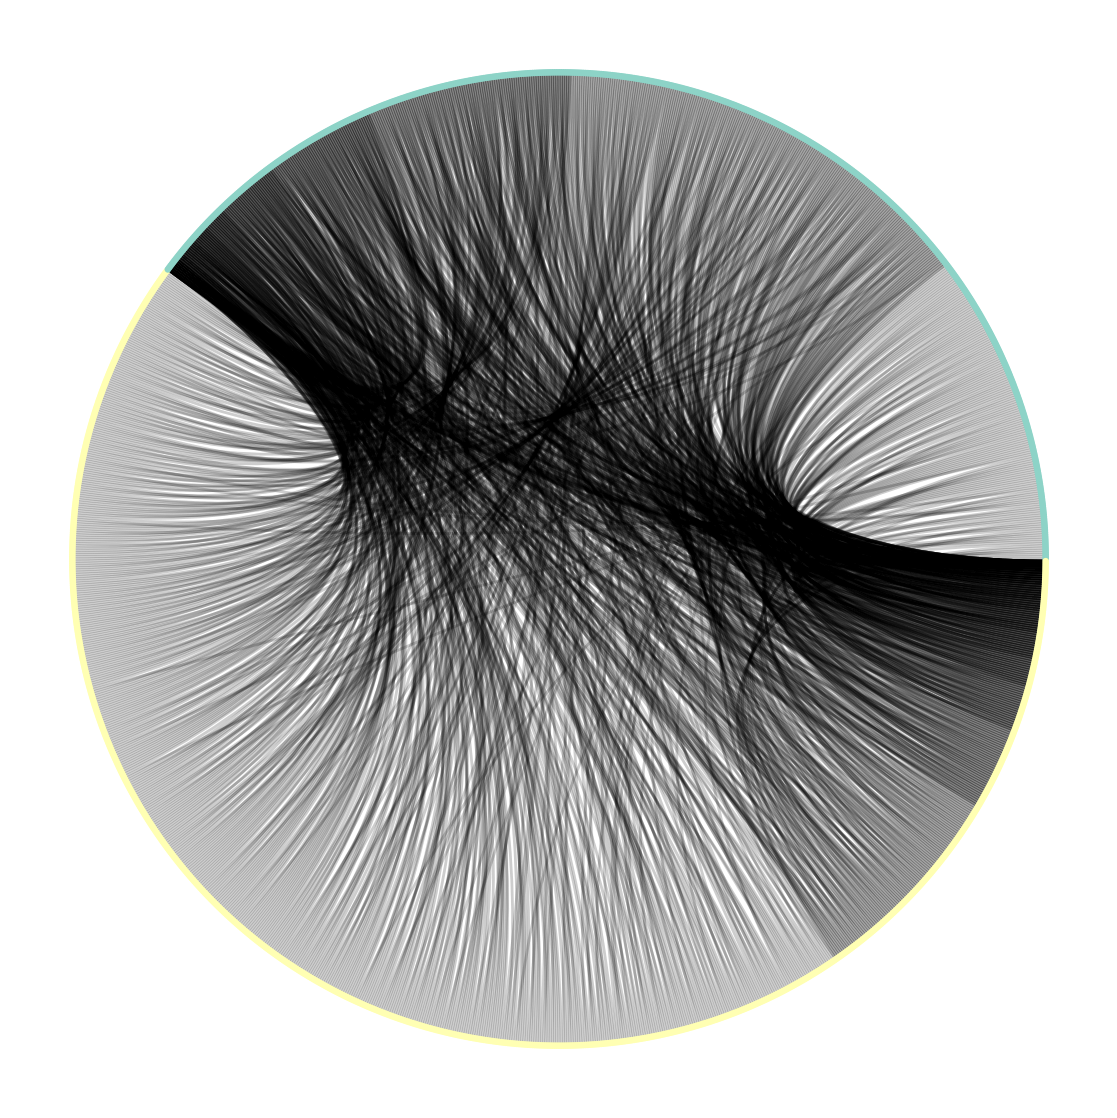

In [26]:
import nxviz as nv
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 7))
nv.circos(G, sort_by="degree", group_by="bipartite", node_color_by="bipartite", node_enc_kwargs={"size_scale": 3})

#### Exercise: Extract each node set
A useful thing to be able to do is to extract each partition's node set. This will become handy when interacting with NetworkX's bipartite algorithms later on.

Write a function that extracts all of the nodes from specified node partition. It should also raise a plain Exception if no nodes exist in that specified partition. (as a precuation against users putting in invalid partition names).

In [ ]:
def extract_partition_nodes(G: nx.Graph, partition: str):
    nodeset = [_ for _, _ in _______ if ____________]
    if _____________:
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

### Bipartite Graph Projections
In a bipartite graph, one task that can be useful to do is to calculate the projection of a graph onto one of its nodes.

What do we mean by the "projection of a graph"? It is best visualized using this figure:

In [53]:
def bipartite_example_graph():
    bG = nx.Graph()
    bG.add_nodes_from("abcd", bipartite="letters")
    bG.add_nodes_from(range(1, 4), bipartite="numbers")
    bG.add_edges_from([("a", 1), ("b", 1), ("b", 3), ("c", 2), ("c", 3), ("d", 1)])

    return bG

def draw_bipartite_graph_example():
    """Draw an example bipartite graph and its corresponding projection."""
    import matplotlib.pyplot as plt
    import nxviz as nv
    from nxviz import annotate, plots, highlights

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    plt.sca(ax[0])
    bG = bipartite_example_graph()
    nv.parallel(bG, group_by="bipartite", node_color_by="bipartite")
    annotate.parallel_group(bG, group_by="bipartite", y_offset=-0.5)
    highlights.parallel_edge(bG, "a", 1, group_by="bipartite")
    highlights.parallel_edge(bG, "b", 1, group_by="bipartite")

    pG = nx.bipartite.projected_graph(bG, nodes=list("abcd"))
    plt.sca(ax[1])
    nv.arc(pG)
    highlights.arc_edge(pG, "a", "b")

    bG = nx.bipartite.projected_graph(bG, nodes=[1,2,3])
    plt.sca(ax[2])
    nv.arc(bG)
    return ax

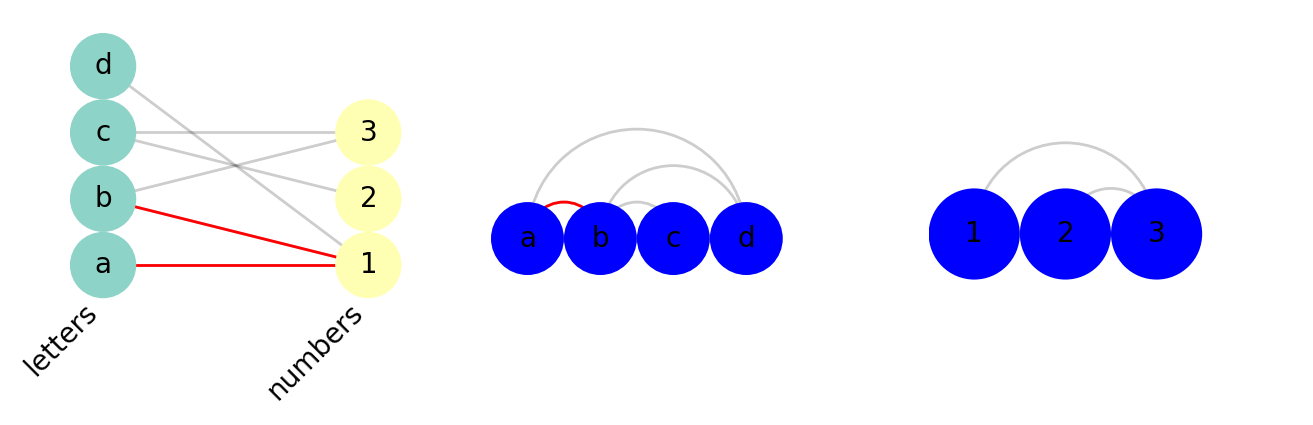

In [57]:
from nxviz import annotate
import matplotlib.pyplot as plt

bG = bipartite_example_graph()

# get the projection on letter class
pG = nx.bipartite.projection.projected_graph(bG, "abcd")
cG = nx.bipartite.projection.projected_graph(bG, [1,2,3])
ax = draw_bipartite_graph_example()

plt.sca(ax[0])
annotate.parallel_labels(bG, group_by="bipartite")

plt.sca(ax[1])
annotate.arc_labels(pG)

plt.sca(ax[2])
annotate.arc_labels(cG)

As shown in the figure above, we start first with a bipartite graph with two node sets, the "alphabet" set and the "numeric" set. The projection of this bipartite graph onto the "alphabet" node set is a graph that is constructed such that it only contains the "alphabet" nodes, and edges join the "alphabet" nodes because they share a connection to a "numeric" node. The red edge on the right is basically the red path traced on the left.

### Computing graph projections
How does one compute graph projections using NetworkX? Turns out, NetworkX has a bipartite submodule, which gives us all of the facilities that we need to interact with bipartite algorithms.

First of all, we need to check that the graph is indeed a bipartite graph. NetworkX provides a function for us to do so:




In [31]:
from networkx.algorithms import bipartite

bipartite.is_bipartite(G)

True

Now that we've confirmed that the graph is indeed bipartite, we can use the NetworkX bipartite submodule functions to generate the bipartite projection onto one of the node partitions.

First off, we need to extract nodes from a particular partition.

In [33]:
def extract_partition_nodes(G: nx.Graph, partition: str):
    nodeset = [n for n, d in G.nodes(data=True) if d["bipartite"] == partition]
    if len(nodeset) == 0:
        raise Exception(f"No nodes exist in the partition {partition}!")
    return nodeset

In [34]:
person_nodes = extract_partition_nodes(G, "person")
crime_nodes = extract_partition_nodes(G, "crime")

Next, we can compute the projection:

In [35]:
person_graph = bipartite.projected_graph(G, person_nodes)
crime_graph = bipartite.projected_graph(G, crime_nodes)

And with that, we have our projected graphs!

Go ahead and inspect them:

In [36]:
list(person_graph.edges(data=True))[0:5]


[('p1', 'p336', {}),
 ('p1', 'p93', {}),
 ('p1', 'p694', {}),
 ('p1', 'p756', {}),
 ('p2', 'p39', {})]

In [37]:
list(crime_graph.edges(data=True))[0:5]


[('c1', 'c3', {}),
 ('c1', 'c4', {}),
 ('c1', 'c2', {}),
 ('c2', 'c4', {}),
 ('c2', 'c3', {})]

Now, what is the interpretation of these projected graphs?

- For person_graph, we have found individuals who are linked by shared participation (whether witness or suspect) in a crime.
- For crime_graph, we have found crimes that are linked by shared involvement by people.
  
Just by this graph, we already can find out pretty useful information. Let's use an exercise that leverages what you already know to extract useful information from the projected graph.

#### Exercise: find the crime(s) that have the most shared connections with other crimes

    Find crimes that are most similar to one another on the basis of the number of shared connections to individuals.

Hint: This is a degree centrality problem!

In [ ]:
import pandas as pd

def find_most_similar_crimes(cG: nx.Graph):
    """
    Find the crimes that are most similar to other crimes.
    """
    dcs = ______________
    return ___________________

#### Exercise: find the individual(s) that have the most shared connections with other individuals

    Now do the analogous thing for individuals!

In [ ]:
def find_most_similar_people(pG: nx.Graph):
    """
    Find the persons that are most similar to other persons.
    """
    dcs = ______________
    return ___________________

## Weighted Projection
Though we were able to find out which graphs were connected with one another, we did not record in the resulting projected graph the strength by which the two nodes were connected. To preserve this information, we need another function:

In [41]:
weighted_person_graph = bipartite.weighted_projected_graph(G, person_nodes)
list(weighted_person_graph.edges(data=True))[0:10]

[('p1', 'p336', {'weight': 1}),
 ('p1', 'p93', {'weight': 1}),
 ('p1', 'p694', {'weight': 1}),
 ('p1', 'p756', {'weight': 1}),
 ('p2', 'p39', {'weight': 1}),
 ('p2', 'p578', {'weight': 1}),
 ('p2', 'p781', {'weight': 1}),
 ('p2', 'p287', {'weight': 1}),
 ('p2', 'p90', {'weight': 1}),
 ('p2', 'p309', {'weight': 1})]

#### Exercise: Find the people that can help with investigating a crime's person.
Let's pretend that we are a detective trying to solve a crime, and that we right now need to find other individuals who were not implicated in the same exact crime as an individual was, but who might be able to give us information about that individual because they were implicated in other crimes with that individual.

    Implement a function that takes in a bipartite graph G, a string person and a string crime, and returns a list of other persons that were not implicated in the crime, but were connected to the person via other crimes. It should return a ranked list, based on the number of shared crimes (from highest to lowest) because the ranking will help with triage.

In [42]:
list(G.neighbors('p1'))

['c1', 'c2', 'c3', 'c4']

In [ ]:
def find_connected_persons(G, person, crime):
    # Step 0: Check that the given "person" and "crime" are connected.
    if _____________________________:
        raise ValueError(f"Graph does not have a connection between {person} and {crime}!")

    # Step 1: calculate weighted projection for person nodes.
    person_nodes = ____________________________________
    person_graph = bipartite.________________________(_, ____________)

    # Step 2: Find neighbors of the given `person` node in projected graph.
    candidate_neighbors = ___________________________________

    # Step 3: Remove candidate neighbors from the set if they are implicated in the given crime.
    for p in G.neighbors(crime):
        if ________________________:
            _____________________________

    # Step 4: Rank-order the candidate neighbors by number of shared connections.
    _________ = []
    ## You might need a for-loop here
    return pd.DataFrame(__________).sort_values("________", ascending=False)


### Degree Centrality
The degree centrality metric is something we can calculate for bipartite graphs. Recall that the degree centrality metric is the number of neighbors of a node divided by the total number of possible neighbors.

In a unipartite graph, the denominator can be the total number of nodes less one (if self-loops are not allowed) or simply the total number of nodes (if self loops are allowed).

### What is the denominator for bipartite graphs?

The total number of neighbors that a node can possibly have is the number of nodes in the other partition. This comes naturally from the definition of a bipartite graph, where nodes can only be connected to nodes in the other partition.

#### Exercise: Which persons are implicated in the most number of crimes?
Find the persons (singular or plural) who are connected to the most number of crimes.

To do so, you will need to use nx.bipartite.degree_centrality, rather than the regular nx.degree_centrality function.

nx.bipartite.degree_centrality requires that you pass in a node set from one of the partitions so that it can correctly partition nodes on the other set. What is returned, though, is the degree centrality for nodes in both sets. Here is an example to show you how the function is used: